In [1]:
# Install libraries if you don't have them (Colab usually has these pre-installed, but it's good practice)
# !pip install pandas matplotlib seaborn requests

In [2]:
!pip install flask flask-cors pyngrok
!pip install pandas matplotlib seaborn requests

In [3]:
#Import Libraries
#------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime

# Configure plotting for better visuals
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

In [4]:
#ThingSpeak Configuration:
#------------------------------------------------------
CHANNEL_ID = 2992009 # Your ThingSpeak Channel ID
READ_API_KEY = "57TLMVDKZJBFOYX3" # Replace with your Read API Key if your channel is private or you want to use the API key

# ThingSpeak API endpoint for reading channel feed
# For JSON format with custom number of entries:
THINGSPEAK_URL = f"https://api.thingspeak.com/channels/2992009/feeds.json"

In [5]:
#Fetch Data:
#------------------------------------------------------
def fetch_thingspeak_data(channel_id, read_api_key, results=5000):
    """
    Fetches data from a ThingSpeak channel.

    Args:
        channel_id (int): Your ThingSpeak Channel ID.
        read_api_key (str): Your ThingSpeak Read API Key.
        results (int): Number of last entries to retrieve. Max 8000 for free tier.

    Returns:
        pandas.DataFrame: A DataFrame containing the sensor data.
    """
    params = {
        'api_key': read_api_key,
        'results': results
    }
    try:
        response = requests.get(THINGSPEAK_URL, params=params)
        response.raise_for_status() # Raise an exception for HTTP errors (4xx or 5xx)
        data = response.json()

        if 'feeds' not in data:
            print("Error: 'feeds' key not found in ThingSpeak response.")
            print(data) # Print full response for debugging
            return pd.DataFrame()

        df = pd.DataFrame(data['feeds'])

        # Rename columns for clarity based on your code: Field 1 is Temperature, Field 2 is Humidity
        df = df.rename(columns={'field1': 'Temperature', 'field2': 'Humidity'})

        # Convert 'created_at' to datetime objects and set as index
        df['created_at'] = pd.to_datetime(df['created_at'])
        df = df.set_index('created_at')

        # Convert sensor data columns to numeric, coercing errors to NaN
        df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
        df['Humidity'] = pd.to_numeric(df['Humidity'], errors='coerce')

        return df[['Temperature', 'Humidity']] # Select only the relevant columns

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from ThingSpeak: {e}")
        return pd.DataFrame()
    except ValueError as e:
        print(f"Error parsing JSON response: {e}")
        return pd.DataFrame()

# Fetch your data
df = fetch_thingspeak_data(CHANNEL_ID, READ_API_KEY, results=2000) # Fetch last 2000 entries

if not df.empty:
    print("Data fetched successfully. First 5 rows:")
    print(df.head())
    print("\nData Info:")
    df.info()
    print("\nData Description:")
    print(df.describe())
else:
    print("Failed to fetch data or data is empty.")

Data fetched successfully. First 5 rows:
                           Temperature  Humidity
created_at                                      
2025-06-21 11:21:17+00:00         31.4      74.1
2025-06-21 11:21:32+00:00         31.4      74.1
2025-06-21 11:22:01+00:00         31.4      74.2
2025-06-21 11:22:17+00:00         31.4      74.3
2025-06-21 11:22:47+00:00         31.4      74.3

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2000 entries, 2025-06-21 11:21:17+00:00 to 2025-06-22 07:12:21+00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  2000 non-null   float64
 1   Humidity     2000 non-null   float64
dtypes: float64(2)
memory usage: 46.9 KB

Data Description:
       Temperature    Humidity
count  2000.000000  2000.00000
mean     31.598650    77.90775
std       0.751149     4.48980
min      29.900000    66.60000
25%      30.900000    75.60000
50%      31.550000    78.70000
75%  

In [6]:
#FPart 2: Data Cleaning in Google Colab : Check for Missing Values:
#------------------------------------------------------
if not df.empty:
    print("\nMissing values before cleaning:")
    print(df.isnull().sum())




Missing values before cleaning:
Temperature    0
Humidity       0
dtype: int64


In [7]:
#FPart 2: Data Cleaning in Google Colab : Handle Missing Values:
#------------------------------------------------------
if not df.empty:
    # Option 1: Drop rows with any missing values (be careful, might lose too much data)
    # df_cleaned = df.dropna()
    # print(f"\nShape after dropping NaNs: {df_cleaned.shape}")

    # Option 2: Forward fill and then backward fill (good for time series)
    # This fills NaNs with the last valid observation, then any remaining NaNs (at the start) with the next valid observation.
    df_cleaned = df.fillna(method='ffill').fillna(method='bfill')
    print("\nMissing values after ffill/bfill imputation:")
    print(df_cleaned.isnull().sum())

    # Option 3: Interpolate missing values (often best for sensor data)
    # df_cleaned = df.interpolate(method='time') # 'time' is good if your index is datetime
    # print("\nMissing values after time-based interpolation:")
    # print(df_cleaned.isnull().sum())

    # If there are still NaNs after interpolation (e.g., at very beginning/end) you might still need a ffill/bfill
    df_cleaned = df_cleaned.fillna(method='ffill').fillna(method='bfill')

    print("\nCleaned Data Info:")
    df_cleaned.info()


Missing values after ffill/bfill imputation:
Temperature    0
Humidity       0
dtype: int64

Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2000 entries, 2025-06-21 11:21:17+00:00 to 2025-06-22 07:12:21+00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  2000 non-null   float64
 1   Humidity     2000 non-null   float64
dtypes: float64(2)
memory usage: 46.9 KB


/tmp/ipython-input-7-4063869047.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned = df.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-7-4063869047.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned = df_cleaned.fillna(method='ffill').fillna(method='bfill')


In [8]:
#FPart 2: Data Cleaning in Google Colab : Check for Duplicates:
#------------------------------------------------------
if not df_cleaned.empty:
    print(f"\nNumber of duplicate rows (based on index/timestamp): {df_cleaned.index.duplicated().sum()}")
    # If there are duplicates and you want to remove them, typically keep the first or last
    # df_cleaned = df_cleaned[~df_cleaned.index.duplicated(keep='first')]
    # print(f"Shape after removing duplicates: {df_cleaned.shape}")


Number of duplicate rows (based on index/timestamp): 0


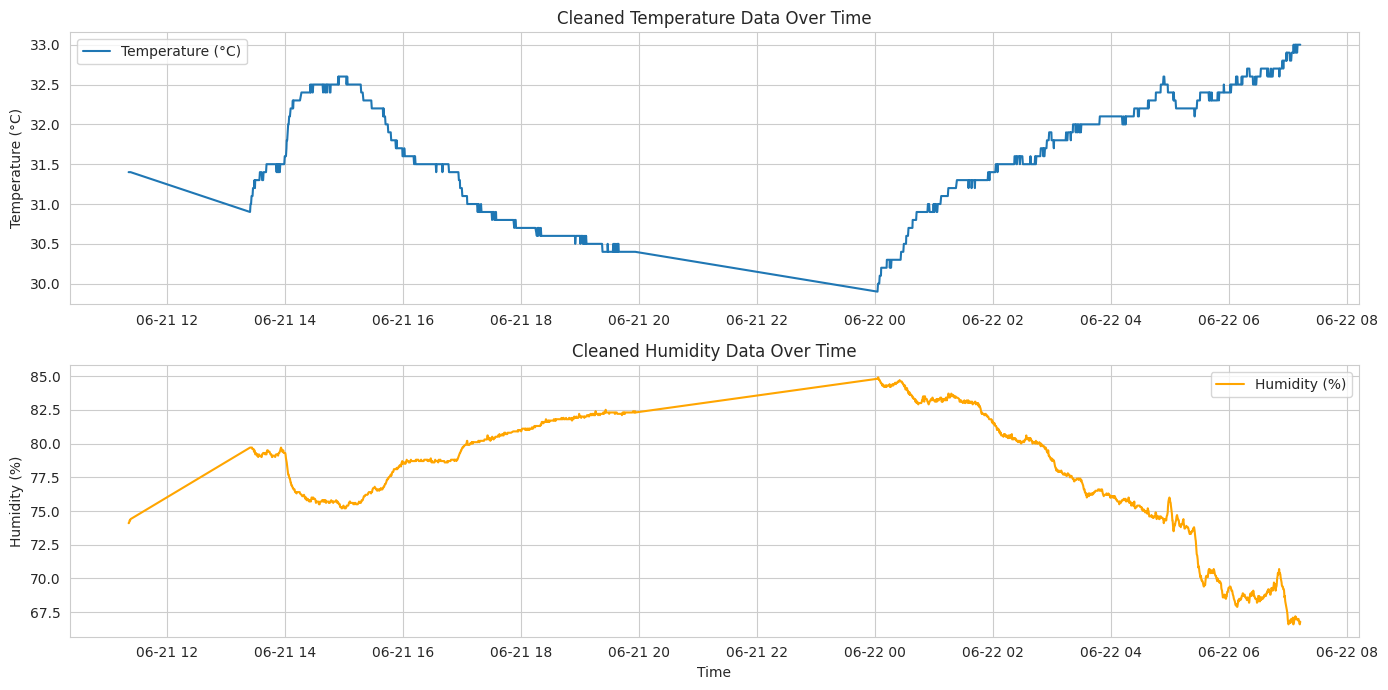

In [9]:
#Data Cleaning in Google Colab : Visualize Cleaned Data:
#------------------------------------------------------
if not df_cleaned.empty:
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 1, 1)
    plt.plot(df_cleaned.index, df_cleaned['Temperature'], label='Temperature (°C)')
    plt.title('Cleaned Temperature Data Over Time')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(df_cleaned.index, df_cleaned['Humidity'], color='orange', label='Humidity (%)')
    plt.title('Cleaned Humidity Data Over Time')
    plt.ylabel('Humidity (%)')
    plt.xlabel('Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Temperature Anomalies (Z-Score):
Empty DataFrame
Columns: [Temperature, Humidity, Temp_ZScore, Temp_Anomaly_ZScore, Hum_ZScore, Hum_Anomaly_ZScore]
Index: []

Humidity Anomalies (Z-Score):
Empty DataFrame
Columns: [Temperature, Humidity, Temp_ZScore, Temp_Anomaly_ZScore, Hum_ZScore, Hum_Anomaly_ZScore]
Index: []


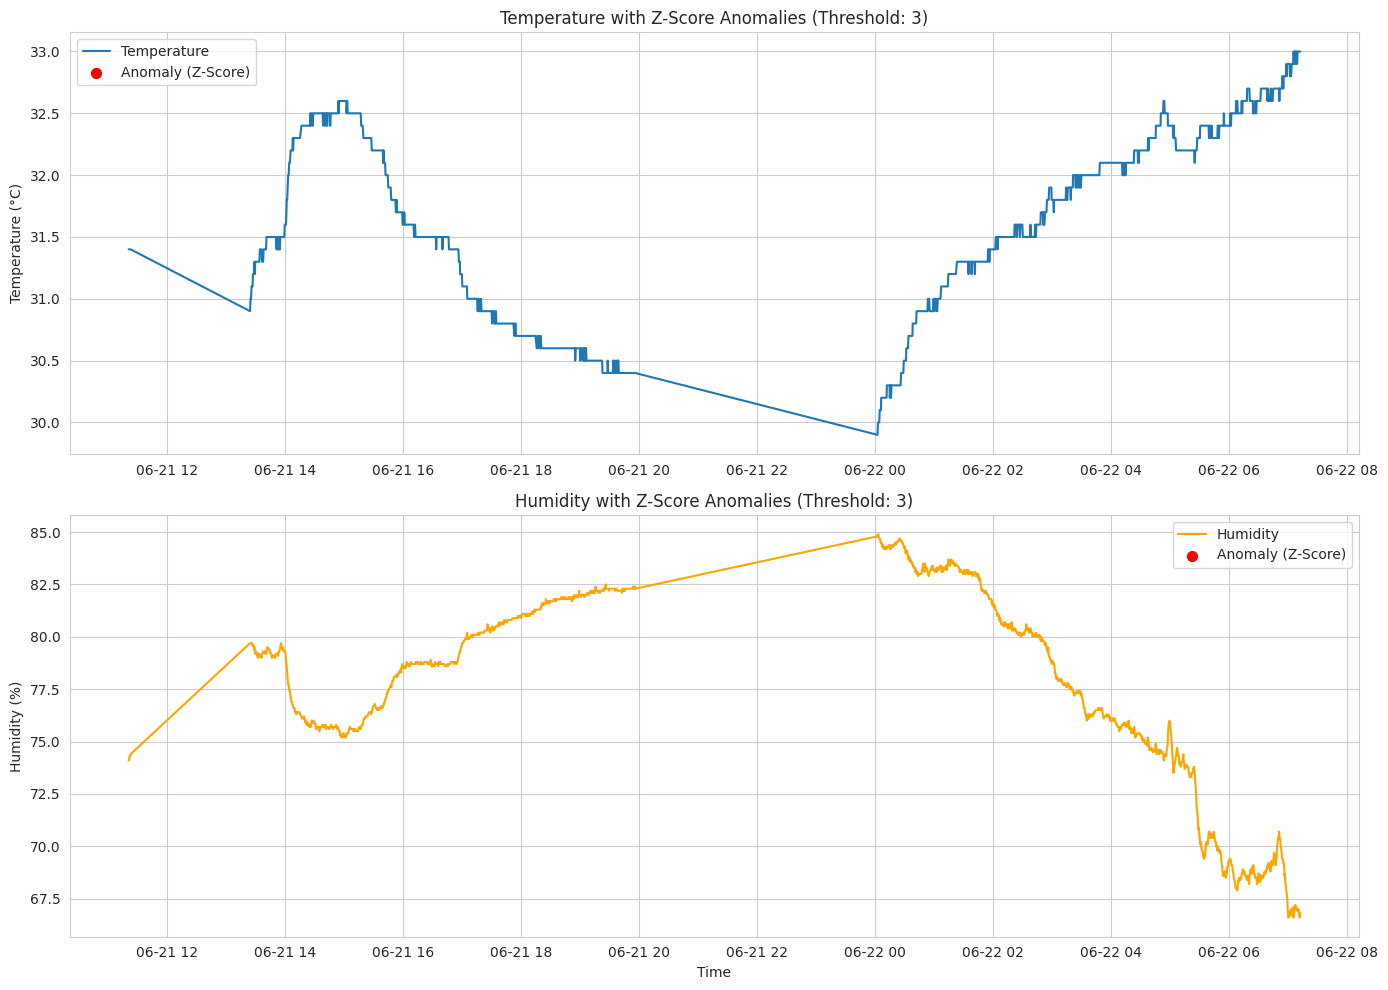

In [10]:
#Part 3: Anomaly Detection in Google Colab: Method 1: Simple Z-Score (Statistical Thresholding)
#This method identifies data points that are a certain number of standard deviations away from the mean.
#-----------------------------------------------------------------------------------------------------
if not df_cleaned.empty:
    # Define a threshold for Z-score
    Z_SCORE_THRESHOLD = 3

    # Calculate Z-score for Temperature
    df_cleaned['Temp_ZScore'] = (df_cleaned['Temperature'] - df_cleaned['Temperature'].mean()) / df_cleaned['Temperature'].std()
    df_cleaned['Temp_Anomaly_ZScore'] = (df_cleaned['Temp_ZScore'].abs() > Z_SCORE_THRESHOLD)

    # Calculate Z-score for Humidity
    df_cleaned['Hum_ZScore'] = (df_cleaned['Humidity'] - df_cleaned['Humidity'].mean()) / df_cleaned['Humidity'].std()
    df_cleaned['Hum_Anomaly_ZScore'] = (df_cleaned['Hum_ZScore'].abs() > Z_SCORE_THRESHOLD)

    print("\nTemperature Anomalies (Z-Score):")
    print(df_cleaned[df_cleaned['Temp_Anomaly_ZScore']])

    print("\nHumidity Anomalies (Z-Score):")
    print(df_cleaned[df_cleaned['Hum_Anomaly_ZScore']])

    # Visualize Z-score anomalies
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 1, 1)
    plt.plot(df_cleaned.index, df_cleaned['Temperature'], label='Temperature')
    plt.scatter(df_cleaned[df_cleaned['Temp_Anomaly_ZScore']].index, df_cleaned[df_cleaned['Temp_Anomaly_ZScore']]['Temperature'],
                color='red', s=50, label='Anomaly (Z-Score)')
    plt.title(f'Temperature with Z-Score Anomalies (Threshold: {Z_SCORE_THRESHOLD})')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(df_cleaned.index, df_cleaned['Humidity'], color='orange', label='Humidity')
    plt.scatter(df_cleaned[df_cleaned['Hum_Anomaly_ZScore']].index, df_cleaned[df_cleaned['Hum_Anomaly_ZScore']]['Humidity'],
                color='red', s=50, label='Anomaly (Z-Score)')
    plt.title(f'Humidity with Z-Score Anomalies (Threshold: {Z_SCORE_THRESHOLD})')
    plt.ylabel('Humidity (%)')
    plt.xlabel('Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Temperature Anomalies (Isolation Forest):
                           Temperature  Humidity  Temp_ZScore  \
created_at                                                      
2025-06-22 00:02:35+00:00         29.9      84.8    -2.261401   
2025-06-22 00:03:05+00:00         30.0      84.9    -2.128272   
2025-06-22 00:03:20+00:00         30.0      84.9    -2.128272   
2025-06-22 00:03:50+00:00         30.0      84.8    -2.128272   
2025-06-22 00:04:05+00:00         30.0      84.7    -2.128272   
2025-06-22 00:04:20+00:00         30.0      84.7    -2.128272   
2025-06-22 07:05:36+00:00         33.0      66.8     1.865608   
2025-06-22 07:06:51+00:00         33.0      67.0     1.865608   
2025-06-22 07:07:21+00:00         33.0      67.2     1.865608   
2025-06-22 07:08:08+00:00         33.0      67.1     1.865608   
2025-06-22 07:08:36+00:00         33.0      67.0     1.865608   
2025-06-22 07:09:37+00:00         33.0      66.9     1.865608   
2025-06-22 07:10:06+00:00         33.0      67.

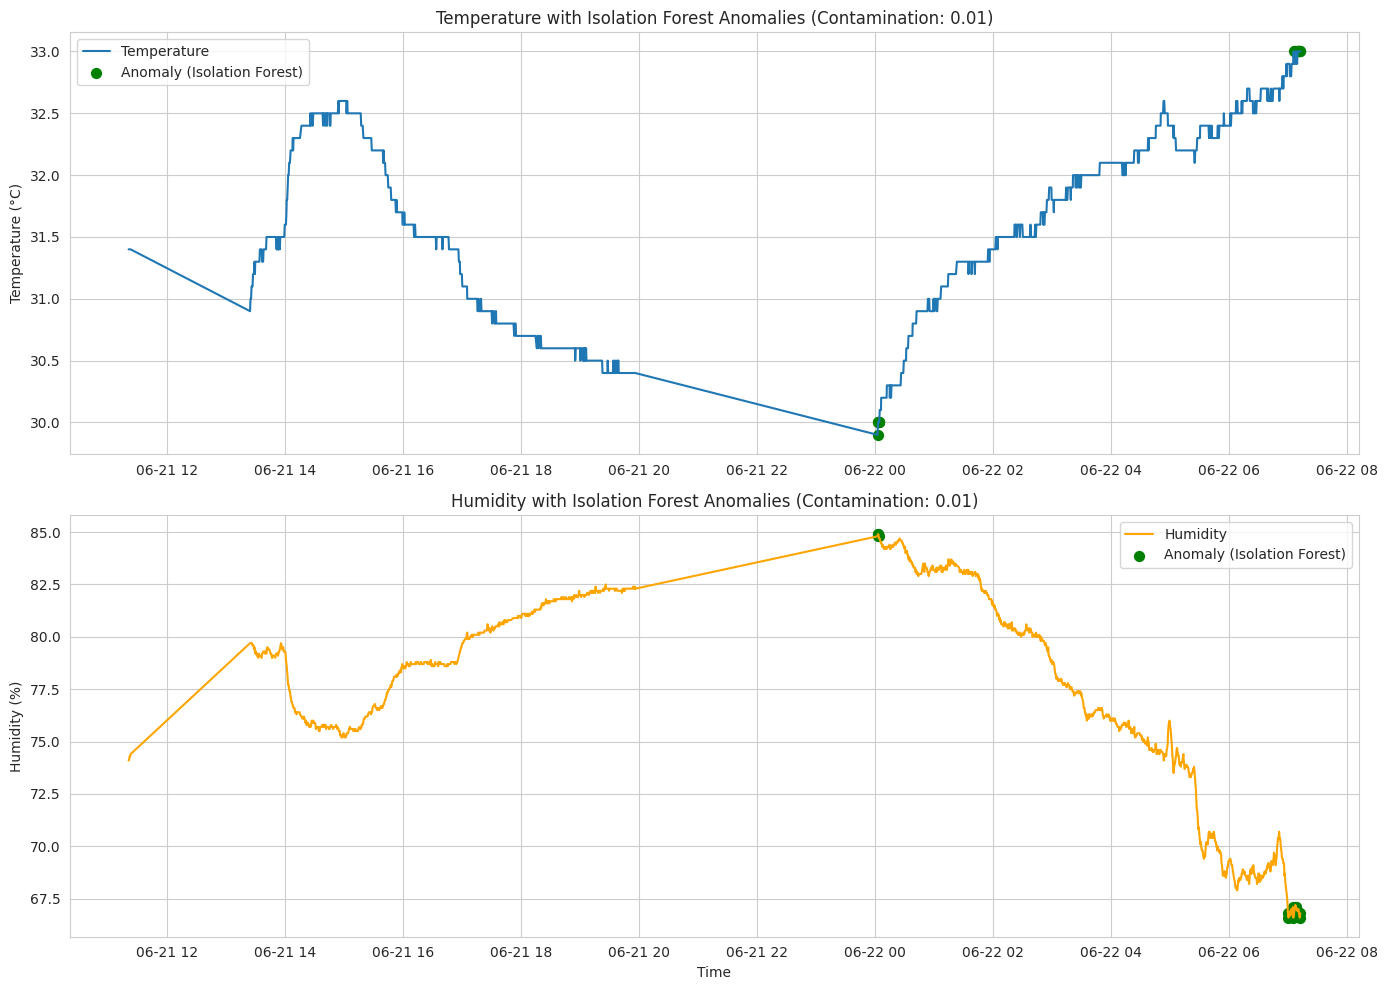

In [11]:

#Part 3: Anomaly Detection in Google Colab:Method 2: Isolation Forest (Machine Learning)
#This method identifies data points that are a certain number of standard deviations away from the mean.
#-----------------------------------------------------------------------------------------------------
#Isolation Forest is an effective algorithm for anomaly detection, especially in higher-dimensional data,
#but it works well on single features too. It "isolates" anomalies by randomly picking a feature and then randomly
#picking #a split value between the maximum and minimum values of the selected feature. Anomalies are those points that have
# shorter average path lengths in the trees.
if not df_cleaned.empty:
    from sklearn.ensemble import IsolationForest

    # Prepare data for Isolation Forest
    # For a single feature, you need to reshape it
    X_temp = df_cleaned['Temperature'].values.reshape(-1, 1)
    X_hum = df_cleaned['Humidity'].values.reshape(-1, 1)

    # You can train one model per feature, or combine features if they are related
    # For now, let's do them separately.

    # Isolation Forest for Temperature
    iso_forest_temp = IsolationForest(contamination=0.01, random_state=42) # contamination is the expected proportion of outliers in the data
    df_cleaned['Temp_Anomaly_IF'] = iso_forest_temp.fit_predict(X_temp)
    # Convert -1 (anomaly) to True, 1 (normal) to False
    df_cleaned['Temp_Anomaly_IF'] = df_cleaned['Temp_Anomaly_IF'] == -1

    # Isolation Forest for Humidity
    iso_forest_hum = IsolationForest(contamination=0.01, random_state=42)
    df_cleaned['Hum_Anomaly_IF'] = iso_forest_hum.fit_predict(X_hum)
    df_cleaned['Hum_Anomaly_IF'] = df_cleaned['Hum_Anomaly_IF'] == -1

    print("\nTemperature Anomalies (Isolation Forest):")
    print(df_cleaned[df_cleaned['Temp_Anomaly_IF']])

    print("\nHumidity Anomalies (Isolation Forest):")
    print(df_cleaned[df_cleaned['Hum_Anomaly_IF']])

    # Visualize Isolation Forest anomalies
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 1, 1)
    plt.plot(df_cleaned.index, df_cleaned['Temperature'], label='Temperature')
    plt.scatter(df_cleaned[df_cleaned['Temp_Anomaly_IF']].index, df_cleaned[df_cleaned['Temp_Anomaly_IF']]['Temperature'],
                color='green', s=50, label='Anomaly (Isolation Forest)')
    plt.title(f'Temperature with Isolation Forest Anomalies (Contamination: 0.01)')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(df_cleaned.index, df_cleaned['Humidity'], color='orange', label='Humidity')
    plt.scatter(df_cleaned[df_cleaned['Hum_Anomaly_IF']].index, df_cleaned[df_cleaned['Hum_Anomaly_IF']]['Humidity'],
                color='green', s=50, label='Anomaly (Isolation Forest)')
    plt.title(f'Humidity with Isolation Forest Anomalies (Contamination: 0.01)')
    plt.ylabel('Humidity (%)')
    plt.xlabel('Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Temperature Anomalies (Moving Avg/Std Dev):
                           Temperature  Humidity  Temp_ZScore  \
created_at                                                      
2025-06-21 14:38:59+00:00         32.4      75.7     1.066832   
2025-06-21 16:33:59+00:00         31.4      78.7    -0.264461   
2025-06-21 16:40:18+00:00         31.4      78.7    -0.264461   
2025-06-21 17:19:32+00:00         31.0      80.2    -0.796979   
2025-06-21 17:30:47+00:00         30.8      80.5    -1.063237   
2025-06-21 17:53:17+00:00         30.7      80.9    -1.196367   
2025-06-21 18:55:17+00:00         30.5      81.9    -1.462625   
2025-06-21 19:00:32+00:00         30.5      82.0    -1.462625   
2025-06-21 19:28:17+00:00         30.5      82.3    -1.462625   
2025-06-22 01:35:05+00:00         31.2      83.1    -0.530720   
2025-06-22 01:41:35+00:00         31.2      83.1    -0.530720   
2025-06-22 02:27:20+00:00         31.5      80.1    -0.131332   
2025-06-22 02:38:05+00:00         31.6      8

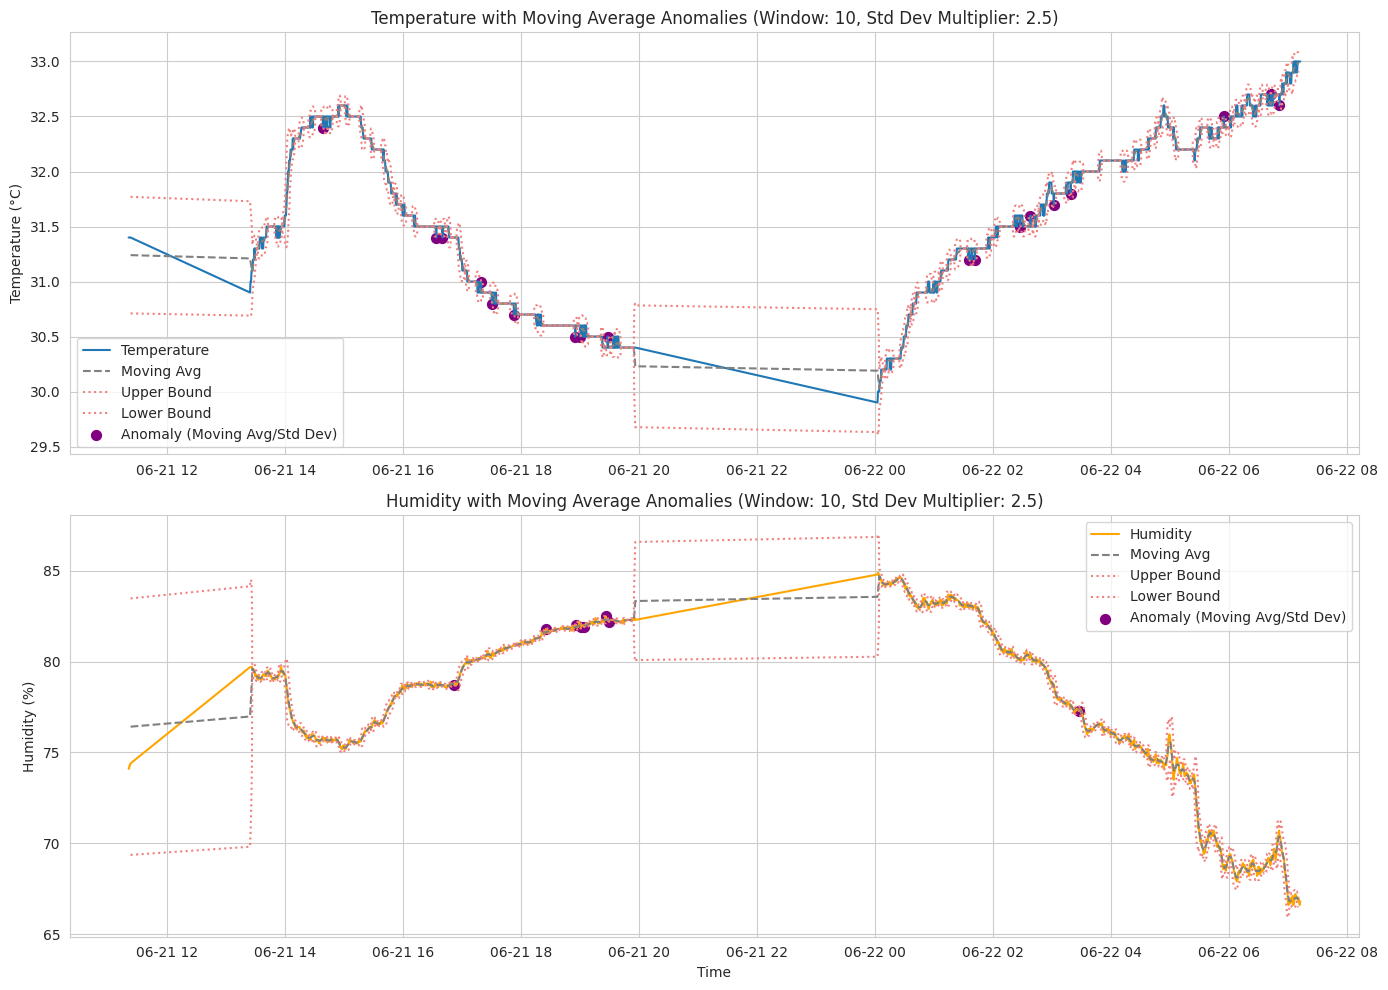

In [12]:
#Part 3: Anomaly Detection in Google Colab:Method 3: Moving Average & Standard Deviation (Time-Series Specific)
#This method identifies data points that are a certain number of standard deviations away from the mean.
#-----------------------------------------------------------------------------------------------------
#This method is good for detecting deviations from recent behavior, rather than global statistics.
if not df_cleaned.empty:
    WINDOW_SIZE = 10 # Number of data points for the moving window
    STD_DEV_MULTIPLIER = 2.5 # How many standard deviations away from the moving mean is considered an anomaly

    # Calculate moving average and standard deviation for Temperature
    df_cleaned['Temp_MA'] = df_cleaned['Temperature'].rolling(window=WINDOW_SIZE, center=True).mean()
    df_cleaned['Temp_Std'] = df_cleaned['Temperature'].rolling(window=WINDOW_SIZE, center=True).std()
    df_cleaned['Temp_Upper_Bound'] = df_cleaned['Temp_MA'] + (df_cleaned['Temp_Std'] * STD_DEV_MULTIPLIER)
    df_cleaned['Temp_Lower_Bound'] = df_cleaned['Temp_MA'] - (df_cleaned['Temp_Std'] * STD_DEV_MULTIPLIER)

    df_cleaned['Temp_Anomaly_MA'] = (df_cleaned['Temperature'] > df_cleaned['Temp_Upper_Bound']) | \
                                    (df_cleaned['Temperature'] < df_cleaned['Temp_Lower_Bound'])

    # Calculate moving average and standard deviation for Humidity
    df_cleaned['Hum_MA'] = df_cleaned['Humidity'].rolling(window=WINDOW_SIZE, center=True).mean()
    df_cleaned['Hum_Std'] = df_cleaned['Humidity'].rolling(window=WINDOW_SIZE, center=True).std()
    df_cleaned['Hum_Upper_Bound'] = df_cleaned['Hum_MA'] + (df_cleaned['Hum_Std'] * STD_DEV_MULTIPLIER)
    df_cleaned['Hum_Lower_Bound'] = df_cleaned['Hum_MA'] - (df_cleaned['Hum_Std'] * STD_DEV_MULTIPLIER)

    df_cleaned['Hum_Anomaly_MA'] = (df_cleaned['Humidity'] > df_cleaned['Hum_Upper_Bound']) | \
                                   (df_cleaned['Humidity'] < df_cleaned['Hum_Lower_Bound'])


    print("\nTemperature Anomalies (Moving Avg/Std Dev):")
    print(df_cleaned[df_cleaned['Temp_Anomaly_MA']])

    print("\nHumidity Anomalies (Moving Avg/Std Dev):")
    print(df_cleaned[df_cleaned['Hum_Anomaly_MA']])


    # Visualize Moving Average anomalies
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 1, 1)
    plt.plot(df_cleaned.index, df_cleaned['Temperature'], label='Temperature')
    plt.plot(df_cleaned.index, df_cleaned['Temp_MA'], label='Moving Avg', color='gray', linestyle='--')
    plt.plot(df_cleaned.index, df_cleaned['Temp_Upper_Bound'], label='Upper Bound', color='lightcoral', linestyle=':')
    plt.plot(df_cleaned.index, df_cleaned['Temp_Lower_Bound'], label='Lower Bound', color='lightcoral', linestyle=':')
    plt.scatter(df_cleaned[df_cleaned['Temp_Anomaly_MA']].index, df_cleaned[df_cleaned['Temp_Anomaly_MA']]['Temperature'],
                color='purple', s=50, label='Anomaly (Moving Avg/Std Dev)')
    plt.title(f'Temperature with Moving Average Anomalies (Window: {WINDOW_SIZE}, Std Dev Multiplier: {STD_DEV_MULTIPLIER})')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(df_cleaned.index, df_cleaned['Humidity'], color='orange', label='Humidity')
    plt.plot(df_cleaned.index, df_cleaned['Hum_MA'], label='Moving Avg', color='gray', linestyle='--')
    plt.plot(df_cleaned.index, df_cleaned['Hum_Upper_Bound'], label='Upper Bound', color='lightcoral', linestyle=':')
    plt.plot(df_cleaned.index, df_cleaned['Hum_Lower_Bound'], label='Lower Bound', color='lightcoral', linestyle=':')
    plt.scatter(df_cleaned[df_cleaned['Hum_Anomaly_MA']].index, df_cleaned[df_cleaned['Hum_Anomaly_MA']]['Humidity'],
                color='purple', s=50, label='Anomaly (Moving Avg/Std Dev)')
    plt.title(f'Humidity with Moving Average Anomalies (Window: {WINDOW_SIZE}, Std Dev Multiplier: {STD_DEV_MULTIPLIER})')
    plt.ylabel('Humidity (%)')
    plt.xlabel('Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()